In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy import sparse
from scipy.sparse import linalg as sl

In [2]:
np.random.seed(42)
rand_mat = np.random.randint(0, 100, (4, 4))

In [3]:
rand_adj = (rand_mat + rand_mat.T) / 2
np.fill_diagonal(rand_adj, 0)

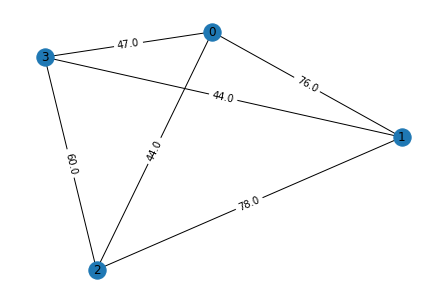

In [4]:
g = nx.Graph(rand_adj)

pos = nx.drawing.layout.random_layout(g, seed=42)
nx.draw(g, pos=pos)
edge_weights = nx.get_edge_attributes(g, "weight")
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_weights)
nx.draw_networkx_labels(g, pos=pos)
plt.show()

In [5]:
nx_solution = nx.algorithms.approximation.traveling_salesman_problem(g)
nx_solution_cost = 0

for i in range(len(nx_solution) - 1):
    nx_solution_cost += g.get_edge_data(nx_solution[i], nx_solution[i + 1])["weight"]

print("NetworkX solution (nodes order):")
print(nx_solution)
print(f"NetworkX solution (total cost): {nx_solution_cost}")

NetworkX solution (nodes order):
[0, 3, 1, 2, 0]
NetworkX solution (total cost): 213.0


In [6]:
def sigma_z_mod(k: int, size: int):
    sz_mod = sparse.coo_matrix(
        [
            [1, 0,],
            [0, 0,],
        ]
    )

    left_ith = sparse.eye(2 ** k, format="coo")
    right_ith = sparse.eye(2 ** (size - k - 1), format="coo")

    return sparse.kron(
        sparse.kron(left_ith, sz_mod),
        right_ith,
    )

In [7]:
eigs = np.linalg.eig(sigma_z_mod(1, 3).toarray())
print(np.unique(eigs[0]))

[0. 1.]


In [8]:
def sigmaz_k(k: int, n: int) -> sparse.csr_matrix:
    left_part = sparse.eye(2 ** k)
    right_part = sparse.eye(2 ** (n - 1 - k))

    return sparse.kron(
        sparse.kron(
            left_part,
            sparse.csr_matrix(np.array([[1, 0,], [0, -1,],]))
        ),
        right_part
    )

def probs2bit_str(probs: np.array) -> str:
    size = int(np.log2(probs.shape[0]))
    bit_s_num = np.where(probs == probs.max())[0][0]
    s = f"{bit_s_num:b}"
    s = "0" * (size - len(s)) + s

    return s

for i, psi in enumerate(eigs[1]):
    probs = psi * psi.conj()
    bit_s = probs2bit_str(probs)
    print(f"Eigenvalue: {eigs[0][i]}\tBit string: {bit_s}")

Eigenvalue: 1.0	Bit string: 000
Eigenvalue: 1.0	Bit string: 001
Eigenvalue: 0.0	Bit string: 010
Eigenvalue: 0.0	Bit string: 011
Eigenvalue: 1.0	Bit string: 100
Eigenvalue: 1.0	Bit string: 101
Eigenvalue: 0.0	Bit string: 110
Eigenvalue: 0.0	Bit string: 111


In [9]:
print("Sigma z_mod:")
print(eigs[1])

print("Sigma z:")
print(np.linalg.eig(sigmaz_k(1, 3).toarray())[1])

Sigma z_mod:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Sigma z:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [10]:
def convert_tsp_to_ising(g: nx.Graph) -> sparse.coo_matrix:
    # У нас два элемента гамильтониана:
    #   - часть, дающая нам Гамилтонов цикл
    #   - часть, считающая стоимость пути
    # Для нас важно, чтобы вес первой части превалирвал.
    # Поэтому, в качестве коэффициента мы берем
    # пятикратное значение максимального веса ребер в графе.

    a = 5 * max([e[2]["weight"] for e in g.edges(data=True)])
    size = g.number_of_nodes() - 1

    H = sparse.coo_matrix((2 ** (size ** 2), 2 ** (size ** 2)), dtype=np.complex)

    # Вычисляем сумму по колонкам:
    #   - каждая вершина должна быть в каждой колонке строго один раз
    for i in range(size):
        # Считаем выражение 1 - sum
        col_sum = sparse.eye(2 ** (size ** 2), format="coo")
        for j in range(size):
            col_sum -= sigma_z_mod(i + j * size, size ** 2)

        # Возводим в квадрат и добавляем к гамилтониану
        H += a * col_sum * col_sum

    # Вычисляем сумму по строкам:
    #   - каждая вершина должна быть в каждой строке строго один раз
    for j in range(size):
        row_sum = sparse.eye(2 ** (size ** 2), format="coo")
        for i in range(size):
            row_sum -= sigma_z_mod(i + j * size, size ** 2)

        # Аналогично, в квадрат и добавляем
        H += a * row_sum * row_sum

    # Считаем сумму по тем ребрам, которых в графе нет и тем, которые есть.
    for i in range(size):
        for j in range(size):
            if g.has_edge(i + 1, j + 1):
                # Сумма по всем ребрам графа
                coef = g.get_edge_data(i + 1, j + 1)["weight"]
            else:
                # Сумма по всем отсутствующим ребрам графа
                coef = a

            for k in range(size - 1):
                # Дальше просто используем полученный коэффициент и считаем сумму
                H += (
                    coef
                    * sigma_z_mod(i + k * size, size ** 2)
                    * sigma_z_mod(j + (k + 1) * size, size ** 2)
                )

            H += (
                coef
                * sigma_z_mod(i + (size - 1) * size, size ** 2)
                * sigma_z_mod(j, size ** 2)
            )

    # Мы всегда начинаем из нулевой вершины, это позволяет нам снизить число необходимых кубитов.
    # Но теперь мы должны добавить в гамильтониан слагаемое, отвечающее за нулевую вершину в пути.
    for j in range(size):
        if g.has_edge(0, j + 1):
            coef = g.get_edge_data(0, j + 1)["weight"]
        else:
            coef = a

        H += coef * sigma_z_mod(j, size ** 2)
        H += coef * sigma_z_mod(j + (size - 1) * size, size ** 2)

    # PennyLane работает с матрицами только в координатном формате, поэтому сразу делаем приведение.
    return sparse.coo_matrix(H)

In [11]:
op = convert_tsp_to_ising(g)
scipy_solution = sl.eigs(op, k=1, which="SR", return_eigenvectors=True)
print(f"Ground state energy: {scipy_solution[0][0]:.4f}")

probs = scipy_solution[1] * scipy_solution[1].conj()
bit_s = probs2bit_str(probs)

# Нулевая вершина всегда первая
scipy_path = [0,]

for i in range(3):
    k = 0
    for j in range(3):
        if bit_s[j + i * 3] == "0":
            k = j + 1
    scipy_path.append(k)
scipy_path.append(0)

scipy_solution_cost = 0
for i in range(len(scipy_path) - 1):
    scipy_solution_cost += g.get_edge_data(scipy_path[i], scipy_path[i + 1])["weight"]

print("SciPy solution (nodes order):")
print(scipy_path)
print(f"SciPy solution (total cost): {scipy_solution_cost}")

Ground state energy: 273.0000-0.0000j
SciPy solution (nodes order):
[0, 2, 1, 3, 0]
SciPy solution (total cost): 213.0


In [12]:
import pennylane as qml

numer_stability_const = 0.1
ham = qml.SparseHamiltonian(op * numer_stability_const, wires=list(range(9)))

In [13]:
size = len(ham.wires)

def layer(params):
    for i in range(size):
        qml.RY(params[i][0], wires=i)
        qml.RZ(params[i][1], wires=i)

    for i in range(size - 1):
        qml.CZ(wires=[i, i + 1])

In [14]:
device = qml.device("default.qubit", wires=size)
num_layers = 3

@qml.qnode(device, diff_method="parameter-shift")
def feed_forward(params, wires=size):
    for k in range(3):
        layer(params[k])

    for i in range(size):
        qml.RY(params[-1][i][0], wires=i)
        qml.RZ(params[-1][i][1], wires=i)

    return qml.expval(ham)

In [15]:
opt = qml.MomentumOptimizer()
params = tuple(
    tuple(
        (
            np.random.rand() * 2 * np.pi,
            np.random.rand() * 2 * np.pi,
        )
        for _ in range(size)
    )
    for _ in range(num_layers + 1)
)

In [16]:
energy = [
    feed_forward(params),
]

for epoch in range(85):
    params, e = opt.step_and_cost(feed_forward, params)
    energy.append(e)

    if epoch % 5 == 0:
        print(f"epoch: {epoch}\tenergy: {e:.6f}")

epoch: 0	energy: 360.638506


epoch: 5	energy: 163.172963


epoch: 10	energy: 96.375950


epoch: 15	energy: 56.524352


epoch: 20	energy: 43.497589


epoch: 25	energy: 35.938162


epoch: 30	energy: 31.882151


epoch: 35	energy: 29.457526


epoch: 40	energy: 29.232270


epoch: 45	energy: 28.058306


epoch: 50	energy: 27.814023


epoch: 55	energy: 27.495886


epoch: 60	energy: 27.479515


epoch: 65	energy: 27.411348


epoch: 70	energy: 27.348231


epoch: 75	energy: 27.329692


epoch: 80	energy: 27.324815


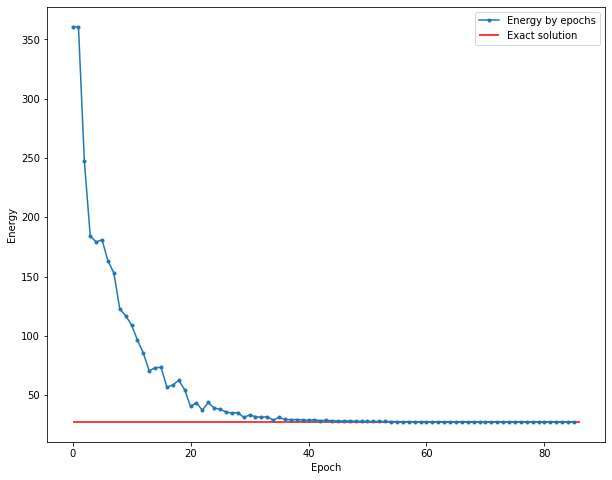

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(energy)), energy, ".-", label="Energy by epochs")
plt.hlines(
    np.real(scipy_solution[0][0]) * numer_stability_const,
    0,
    len(energy),
    color="red",
    label="Exact solution",
)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [18]:
@qml.qnode(device, diff_method="parameter-shift")
def answer(params, wires=size):
    for k in range(num_layers):
        layer(params[k])

    for i in range(size):
        qml.RY(params[-1][i][0], wires=i)
        qml.RZ(params[-1][i][1], wires=i)

    return qml.probs(wires=list(range(size)))

probs = answer(params)
bit_s = probs2bit_str(probs)

# Нулевая вершина всегда первая
q_path = [0,]

for i in range(3):
    k = 0
    for j in range(3):
        if bit_s[j + i * 3] == "0":
            k = j + 1
    q_path.append(k)
q_path.append(0)

q_solution_cost = 0
for i in range(len(q_path) - 1):
    q_solution_cost += g.get_edge_data(q_path[i], q_path[i + 1])["weight"]

print("Quantum solution (nodes order):")
print(q_path)
print(f"Quantum solution (total cost): {q_solution_cost}")

Quantum solution (nodes order):
[0, 2, 1, 3, 0]
Quantum solution (total cost): 213.0
